# Import appropriate modules

In [1]:
import numpy as np
from numpy.linalg import eigh
from numpy import load
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)})

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import Rb87Cs133

import scipy.constants
from scipy.linalg import expm

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.gridspec import GridSpec

from tqdm.notebook import tqdm, trange

import itertools

# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
# plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}\usepackage{mathtools}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [2]:
def label_to_state_no(N,MF,k):
    return np.where((LABELS[:, 0] == N) & (LABELS[:, 1] == MF) & (LABELS[:, 2] == k))[0][0]

def state_no_to_uncoupled_label(state_no):
    i=0
    I1d = round(2*I1)
    I2d = round(2*I2)
    for n in range(0, N_MAX + 1):
        for mn in range(n,-(n+1),-1):
            for mi1 in range(I1d,-I1d-1,-2):
                for mi2 in range(I2d,-I2d-1,-2):
                    if i == state_no:
                        return (n,mn,mi1/2,mi2/2)
                    i+=1

In [3]:
def label_degeneracy(N,MF):
    # Want number of ways of having
    # MF = MN + (M_I1 + M_I2) # NP-Hard Problem SSP (Subset Sum)
    d=0
    I1d=round(2*I1)
    I2d=round(2*I2)
    for MN in range(-N,N+1):
        for M_I1d in range(-I1d,I1d+1,2):
            for M_I2d in range(-I2d,I2d+1,2):
                if 2*MN+M_I1d+M_I2d == 2*MF:
                    d+=1
    return d

In [4]:
def twice_average_fidelity(k,g):
    return ((1 + g**2)**2 + 8*k**2*(-1 + 2*g**2) + 16*k**4)/((1 + g**2)**3 + (-8 + 20*g**2 + g**4)*k**2 + 16*k**4)

# Define 'global' Constants

In [5]:
H_BAR = scipy.constants.hbar

I1 = Rb87Cs133["I1"]
I2 = Rb87Cs133["I2"]
D_0 = Rb87Cs133["d0"]
N_MAX=2

I = 0 #W/m^2
E = 0 #V/m

B_MIN_GAUSS = 0.001
B_MAX_GAUSS = 1000
B_STEPS = 500
PULSE_TIME_US = 500

settings_string = f'NMax{N_MAX}BMin{B_MIN_GAUSS}BMax{B_MAX_GAUSS}BSteps{B_STEPS}PTime{PULSE_TIME_US}'
print(settings_string)

GAUSS = 1e-4 # T
B_MIN = B_MIN_GAUSS * GAUSS # T
B_MAX = B_MAX_GAUSS * GAUSS # T
PULSE_TIME = PULSE_TIME_US * 1e-6 # s

B, B_STEP_SIZE = np.linspace(B_MIN, B_MAX, B_STEPS, retstep=True) #T 

NMax2BMin0.001BMax1000BSteps500PTime500


In [6]:
data = np.load(f'../precomputed/{settings_string}.npz')
ENERGIES = data['energies']
N_STATES = len(ENERGIES[0])
STATES = data['states']
LABELS=data['labels']
MAGNETIC_MOMENTS=data['magnetic_moments'] 
COUPLINGS_ZERO=data['coupling_matrix_zero']
COUPLINGS_MINUS=data['coupling_matrix_minus']
COUPLINGS_PLUS=data['coupling_matrix_plus']
COUPLINGS = COUPLINGS_ZERO+COUPLINGS_MINUS+COUPLINGS_PLUS
POLARISED_COUPLING = [COUPLINGS_ZERO,COUPLINGS_PLUS,COUPLINGS_MINUS]
UNPOLARISED_PAIR_FIDELITIES = data['unpolarised_pair_fidelities']
UNPOLARISED_PAIR_FIDELITIES = UNPOLARISED_PAIR_FIDELITIES + UNPOLARISED_PAIR_FIDELITIES.transpose(1,0,2)
POLARISED_PAIR_FIDELITIES=data['polarised_pair_fidelities']
POLARISED_PAIR_FIDELITIES = POLARISED_PAIR_FIDELITIES + POLARISED_PAIR_FIDELITIES.transpose(1,0,2)

# Simulator

In [20]:
# Driven couplings between states
chosen_states_coupling_labels = np.array([(0,5,0),(1,6,0),(2,6,0),(1,5,0)])
chosen_coupling_labels = [
    (chosen_states_coupling_labels[0],chosen_states_coupling_labels[1]),
    (chosen_states_coupling_labels[1],chosen_states_coupling_labels[2]),
    (chosen_states_coupling_labels[3],chosen_states_coupling_labels[2]),
    (chosen_states_coupling_labels[0],chosen_states_coupling_labels[3]),
]

# With what desired rabi period
global_pulse_time = 1000 * 1e-6 #s
chosen_pulse_time = [global_pulse_time]*4

# At what magnetic field
chosen_bi = 499 #round(B_STEPS*(44.0891/B_MAX_GAUSS))

# Only simulate other states that have strong off resonant coupling
cutoff = 0.999999 # =0 for only these =1 for all states
        
# Simulation resolution
T_STEPS =  [803989,314927,195931,65519,41443,21319,9391,50][1] 

# Simulation time length (how many Rabi periods to show)
TIME = chosen_pulse_time[0]*4

In [21]:
# Compute further constants and indices from molecular parameters
if cutoff == 0:
    chosen_states_labels = chosen_states_coupling_labels
elif cutoff == 1:
    chosen_states_labels = LABELS
else:
    needed_states = np.full(N_STATES, False)
    for (al,bl),pt in zip(chosen_coupling_labels, chosen_pulse_time):
        ai = label_to_state_no(*al)
        bi = label_to_state_no(*bl)
        ks_up = np.abs((ENERGIES[chosen_bi, :] - ENERGIES[chosen_bi, bi, None]) * pt / scipy.constants.h)
        ks_down = np.abs((ENERGIES[chosen_bi, :] - ENERGIES[chosen_bi, ai, None]) * pt / scipy.constants.h)

        gs_unpolarised_up = np.abs(COUPLINGS[chosen_bi, ai, :]/COUPLINGS[chosen_bi, ai, bi])
        gs_unpolarised_down = np.abs(COUPLINGS[chosen_bi, bi, :]/COUPLINGS[chosen_bi, ai, bi])

        fidelities_unpolarised_up = twice_average_fidelity(ks_up,gs_unpolarised_up)
        fidelities_unpolarised_down = twice_average_fidelity(ks_down,gs_unpolarised_down)
        
        needed_states = needed_states + (fidelities_unpolarised_up < cutoff) + (fidelities_unpolarised_down < cutoff)
        chosen_states_labels = LABELS[needed_states]
    print(f"These states passed the cutoff ({cutoff}):")
    print(chosen_states_labels)
    
chosen_states_coupling_subindices = [np.where((chosen_states_labels[:, 0] == N) & (chosen_states_labels[:, 1] == MF) & (chosen_states_labels[:, 2] == k))[0][0] for N,MF,k in chosen_states_coupling_labels]
chosen_states_indices = np.array([label_to_state_no(*label) for label in chosen_states_labels])
chosen_number_of_states = len(chosen_states_indices)

These states passed the cutoff (0.999999):
[[0 5 0]
 [1 4 0]
 [1 5 0]
 [1 6 0]
 [2 4 0]
 [2 5 0]
 [2 6 0]
 [2 7 0]]


In [22]:
# Get Angular Frequency Matrix Diagonal for each B
all_angular = ENERGIES[chosen_bi, :].real / H_BAR # [state]
angular = all_angular[chosen_states_indices]

all_couplings = COUPLINGS[chosen_bi]
couplings = all_couplings[:,chosen_states_indices][chosen_states_indices,:]

# Get driving frequencies & polarisations
driving = []
E_i = []
for (l1,l2), pulse_time in zip(chosen_coupling_labels, chosen_pulse_time):
    i1=label_to_state_no(*l1)
    i2=label_to_state_no(*l2)
    driving.append(np.abs(all_angular[i1]-all_angular[i2]))
    E_i.append((2*np.pi*H_BAR) / (D_0 * all_couplings[i1,i2] * pulse_time))
driving = np.array(driving)
print("Driving (rad/s):", driving)
E_i = np.array(E_i,dtype=np.double)
print("E (V/m):", E_i)

# Construct times
times, DT = np.linspace(0,TIME,num=T_STEPS,retstep=True)

# Construct kinetic time step operator (Matrix Diagonal)
T_OP_DIAG = np.exp(-(1j) * angular * DT/2 )

# Construct potential fixed part time step operator 
ORDER = 8
V_TI_M = (-(1j)*D_0*couplings*DT)/H_BAR
V_TI_M_POWS = np.array([np.linalg.matrix_power(V_TI_M, i)/np.math.factorial(i) for i in range(ORDER)])

# Construct state vector
state_vector = np.zeros((T_STEPS,chosen_number_of_states), dtype=np.cdouble)
state_vector[0,chosen_states_coupling_subindices[0]] = np.sqrt(1)

for t_num in trange(T_STEPS-1):
    pres = E_i*np.cos(driving*times[t_num])
    V_TD_POWS = np.sum(pres)**(np.arange(ORDER))
    V_OP = np.sum(V_TI_M_POWS*V_TD_POWS[:,None,None],axis=0)
    
    DU = T_OP_DIAG[:,None] * V_OP[:,:] * T_OP_DIAG[None,:]
    state_vector[t_num+1] = DU @ state_vector[t_num]

resolution=20
probabilities = np.abs(state_vector[::resolution,:])**2

Driving (rad/s): [6.160e+09 1.232e+10 1.232e+10 6.159e+09]
E (V/m): [2.809e-01 -3.637e-01 3.617e-01 -2.816e-01]


/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_25163/690193082.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  E_i = np.array(E_i,dtype=np.double)


  0%|          | 0/314926 [00:00<?, ?it/s]

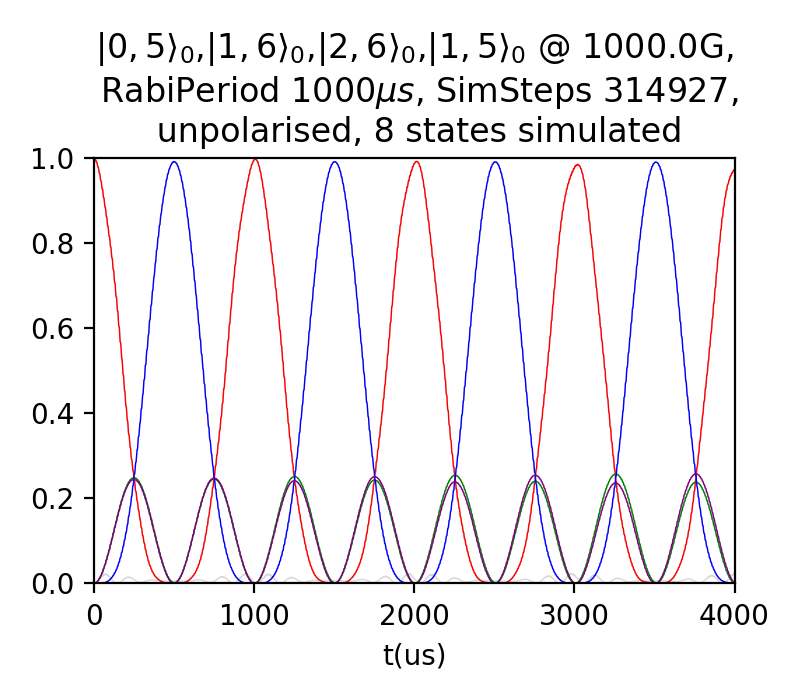

In [23]:
# Plot results
fig,ax = plt.subplots()
ax.set_xlabel('t(us)')
ax.set_ylim(0,1.0)
ax.set_xlim(0,TIME*1e6)
states_string = ','.join(['$|{},{}\\rangle_{{{}}}$'.format(*label) for label in chosen_states_coupling_labels])
ax.set_title('{} @ {}G,\n RabiPeriod {}$\mu s$, SimSteps {},\n unpolarised, {} states simulated'
             .format(states_string,
                     B_MAX_GAUSS*chosen_bi/(B_STEPS-1),
                     round(global_pulse_time*1e6),
                     T_STEPS,
                     chosen_number_of_states))

c = ['red','green','blue','purple']
ax.plot(times[::resolution]*1e6,probabilities[:,:],c='grey',linewidth=0.5,alpha=0.3);
for i,state_subindex in enumerate(chosen_states_coupling_subindices):
    ax.plot(times[::resolution]*1e6,probabilities[:,state_subindex],c=c[i],linewidth=0.5);